# Margin Clearance

This is example of how to extract tumour margins from the segmentations. It is not an automated scripted for all images, but outputs the margins from the 10x test set.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as BoundingBox

import skimage.io as io
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, disk
from skimage.morphology import binary_closing
from skimage.transform import rotate
from skimage.filters import median

from sklearn.linear_model import LinearRegression

from scipy.misc import imrotate


import keras
import keras.backend as K
from keras.layers import Input, Conv2D, GlobalMaxPool2D, Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# Create color palette
color_dict = {
    "EPI":  [73, 0, 106],
    "GLD":  [108, 0, 115],
    "INF":  [145, 1, 122],
    "RET":  [181, 9, 130],
    "FOL":  [216, 47, 148],
    "PAP":  [236, 85, 157],
    "HYP":  [254, 246, 242],
    "KER":  [248, 123, 168],
    "BKG":  [0, 0, 0],
    "BCC":  [127, 255, 255],
    "SCC":  [127, 255, 142],
    "IEC":  [255, 127, 127]
}

LUT = {
      0 : "EPI",
      1 : "GLD",
      2 : "INF",
      3 : "RET",
      4 : "FOL",
      5 : "PAP",
      6 : "HYP",
      7 : "KER",
      8 : "BKG",
      9 : "BCC",
      10 : "SCC",
      11: "IEC"
}

In [3]:
def radians2degress(radians):
    return radians * 180/np.pi

def degrees2radians(degrees):
    return  degrees * (np.pi / 180)

In [4]:
def convert_RGB_to_8bit(image):
    """ returns the 8 bit encoding of the image based on the LUT and color_dict order"""
    segmentation_8bit = np.zeros((image.shape[0], image.shape[1]), dtype="uint8")
    for i in range(12):
        segmentation_8bit[np.all(image == color_dict[LUT[i]], axis=-1)] = i
    return segmentation_8bit

def convert_8bit_to_RGB(image):
    """ returns the rgb encoding of the 8-bit image based on the LUT and color_dict order"""
    segmentation_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype="uint8")
    for i in range(12):
        segmentation_rgb[image == i] = color_dict[LUT[i]]
    return segmentation_rgb

In [5]:
def pad_image(image, value):
    """
    Pads the image to make a square the size of the hypotenuse
    """
    # Find largest axis
    rows, cols = image.shape[0], image.shape[1]
    
    # Find hypotenuse
    hyp = int(np.sqrt(rows**2 + cols**2))
    
    # Calculate size to pad
    pad_width = [[],[],(0, 0)]
    diff = hyp - rows
    extra = diff % 2
    size = diff // 2
    pad_width[0] = [size, size+extra]
    
    
    diff = hyp - cols
    extra = diff % 2
    size = diff // 2
    pad_width[1] = [size, size+extra]

    return np.pad(image, pad_width, mode="constant", constant_values=(value, value))

In [6]:
def get_orientation(segmantation_mask):
    # Get EPI mask
    epi = np.all(segmantation_mask == color_dict["PAP"], axis=-1).astype("int")

    # Get points of EPI
    points = np.where(epi)

    # Reshape coords
    X = points[0].reshape(-1, 1)
    y = points[1].reshape(-1, 1)

    # Fit line
    reg = LinearRegression().fit(X, y)

    # Get predict points
    y1, x1 = np.min(X), np.int(reg.predict(np.array([[np.min(X)]]))[0, 0])
    y2, x2 = np.max(X), np.int(reg.predict(np.array([[np.max(X)]]))[0, 0])
    
    # Get lengths of triangle
    opp = y1 - y2
    adj = x2 - x1

    # Set base angle based on line lengths
    base = 0
    if opp < 0 and adj < 0:
        base = 180
    
    # Calculate angle change
    rads = np.arctan(opp / adj)
    theta = degrees_to_rotate = base - radians2degress(rads)
    radians = degrees2radians(degrees_to_rotate)
    
    # Check if orientation was already upwards
#     whole  = np.all(segmantation_mask != color_dict["BKG"], axis=-1).astype("int")
#     x_centroid, y_centroid = regionprops(whole)[0].centroid
#     y_center = opp / 2
#     if y_centroid > y_center: # Already facing up
#         theta += 180
#         radians == np.pi
    
    return theta, radians, (x1, y1), (x2, y2)

In [7]:
def rotate_image(image, theta, fill=255, median_filter=False):
    """
    Rotates and resizes the image based on theta (in degrees). Value
    is a greyscale color between 0-1.
    
    To Implement:
        resize by padding the image to the largest axis, that way it won't have to rescale
        
    """
    temp = pad_image(image, fill)
    # Convert to 8bit to apply median filters and then back again
    if median_filter:
        temp = convert_8bit_to_RGB(median(convert_RGB_to_8bit(temp), disk(6)))
    temp = rotate(temp, theta, resize=False, cval=fill/255., order=0) # order = 'nearest neighbor'
    return (temp*255.).astype("uint8")

In [8]:
def get_cancer_margins(rotated_segmentation):
    """
    Finds the North, South, East and West extremities of the cancer classes.
    
    Returns the points as (x,y) in the order [N, S, E, W]
    """
    # Get Cancer
    cancer = np.logical_or(
                        np.all(rot_segmentation == color_dict["BCC"], axis=-1),
                        np.logical_or(np.all(rot_segmentation == color_dict["SCC"], axis=-1),
                                           np.all(rot_segmentation == color_dict["IEC"], axis=-1)
                                     )
                    ).astype("int")
    
    # Measure region
    region = regionprops(cancer)[0]

    # Get bounding box coords
    minr, minc, maxr, maxc = region.bbox

    # Get coords for extremeties of cancer
    yN, xN = minr, minc+np.median(np.where(region.convex_image[0, :]))
    yS, xS = minr+(maxr-minr), minc+np.median(np.where(region.convex_image[-1, :]))
    yE, xE = minr+np.median(np.where(region.convex_image[:, -1])), minc+(maxc-minc)
    yW, xW = minr+np.median(np.where(region.convex_image[:, 0])), minc
    
    return (xN, yN), (xS, yS), (xE, yE), (xW, yW)

In [9]:
def get_tissue_margins(rotated_segmentation):
    """
    Find the East and West extremities of the top tissue layers.
    
    Returns the points as (x, y) in the order [E, W]
    """
    # Get Cancer
    top = np.logical_or(
                    np.all(rotated_segmentation == color_dict["EPI"], axis=-1),
                    np.all(rotated_segmentation == color_dict["PAP"], axis=-1)
                   ).astype("int")
    
    # Measure region
    region = regionprops(top)[0]

    # Get bounding box coords
    minr, minc, maxr, maxc = region.bbox

    # Get coords for extremeties of tissue
    yE_tissue, xE_tissue = minr+np.median(np.where(region.convex_image[:, -1])), minc+(maxc-minc)
    yW_tissue, xW_tissue = minr+np.median(np.where(region.convex_image[:, 0])), minc

    return (xE_tissue, yE_tissue), (xW_tissue, yW_tissue)

In [23]:
# Directions stored as x, y
directions_forward  = [[0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1,-1], [-1,0], [-1, 1]]
directions_backward = [[0, 1], [-1,1], [-1,0], [-1,-1], [0, -1], [1, -1], [1, 0], [ 1, 1]]
                                    
def inverse(direction):
    x, y = direction
    return [x*-1, y*-1]

def nextPixel(state, sequence, binary_mask):
    x,y,d = state
    directions = sequence[d::] + sequence[0:d]
    for i, nextdir in enumerate(directions):
        # assume binary_mask[y, x] (rows, cols) is true if pixel x,y is foreground
        if binary_mask[y+nextdir[1], x+nextdir[0]]:
            break
    # Find the position
    inv = inverse(nextdir)
    pos = sequence.index(inv)
    # Start from the previous location + 1 (no immediate repeat)
    d = (pos + 1) % 8
    return([ x+nextdir[0], y+nextdir[1], d ])


def exitCondition(state, color_mask, dist=20, show=False):
    neighborhood = color_mask[state[1]-dist:state[1]+dist, state[0]-dist:state[0]+dist]
    
    if show:
        fig2, ax2 = plt.subplots()
        ax2.imshow(rot_segmentation[state[1]-dist:state[1]+dist, state[0]-dist:state[0]+dist])
        fig.show()
    
    # Model input
    X = neighborhood / 255.
    p = model.predict(np.expand_dims(X, axis=0))[0] 
    if p > 0.9999:
        print(p)
        return True
    
    return False

def get_crawl_start_position(rotated_RGB_segmentation):
    """
    Returns the starting point (x, y) for crawl.
    """
    # Get non-BKG mask
    mask = np.all(rotated_RGB_segmentation != color_dict["BKG"], axis=-1).astype("int")
    # Characterise and get centroid
    region = regionprops(mask)[0]
    x, y1 = region.centroid
    # Get last position of true values
    y2 = np.where(mask[:, int(x)])[0][-1]
    
    return (x, y2), mask

In [24]:
def get_tissue_margin(rotated_segmentation, east=True):
    """
    return (x, y) position of east/west tissue margin. East is 
    forward pass, west is backward.
    """
    # Get starting position
    (x, y), mask = get_crawl_start_position(rotated_segmentation)
    # Set state - 1 for forward sequence : 0 for backward sequence
    state = [int(x), int(y), 0]
    
    # Get 8-bit version
    #color_mask = convert_RGB_to_8bit(rotated_segmentation)
    color_mask = rotated_segmentation
    
    # Set direction
    if east:
        sequence = directions_forward
    else:
        sequence = directions_backward
    
    # Crawl!
    count = 0
    while count < 2e3: # Limit to 5K steps
        state = nextPixel(state, sequence, mask)
        count + 1
        
        if count % 20 == 0:
            if exitCondition(state, color_mask, dist=20):
                break
        
    return (state[0], state[1])

### Run Code

This is a demo of how to orient and measure the surgical margins

In [25]:
#seg_dir = "/home/simon/Documents/PhD/Data/Histo_Segmentation/Datasets_n290/10x/Masks/"
seg_dir = "/home/simon/Desktop/10x_Experiments_Over_Aug/ALL_IMAGES/"
image_dir = "/home/simon/Documents/PhD/Data/Histo_Segmentation/Datasets_n290/10x/Images/"
out_dir = "/home/simon/Desktop/Margins/"

In [26]:
images = [
"IEC_45",
"SCC_23",
"SCC_32",
"BCC_131",
"BCC_135",
"SCC_52",
"SCC_20",
"BCC_4",
"SCC_9",
"BCC_48",
"BCC_80",
"SCC_38",
"BCC_95",
"BCC_86",
"BCC_133",
"IEC_75",
"BCC_51",
"IEC_41",
"BCC_90",
"BCC_74",
"BCC_22",
"SCC_7",
"SCC_24",
"IEC_22",
"IEC_23",
"BCC_60",
"BCC_61",
"IEC_34",
"IEC_35",
"BCC_23",
"BCC_24"
]

In [27]:
ppmm = 0.00067
green = (15/255., 1, 16/255.)

In [28]:
pos = 10
for step, fname in enumerate(images[pos::]):
    
    try:
        print(step+1, "of", len(images), "-", fname)

        segmentation = io.imread(os.path.join(seg_dir, fname) + ".png")
        image = io.imread(os.path.join(image_dir, fname) + ".tif")

        # Get orientation
        print("getting orientation...")
        theta, _, p1, p2 = get_orientation(segmentation)

        # Rotate images
        print("rotating...")
        rot_segmentation = rotate_image(segmentation, theta, 0, median_filter=True)
        rot_image = rotate_image(image, theta, 255, median_filter=False)
 
        # Get Surgical Margins
        print("finding cancer margins...")
        (xN, yN), (xS, yS), (xE, yE), (xW, yW) = get_cancer_margins(rot_segmentation)
        #(xE_tissue, yE_tissue), (xW_tissue, yW_tissue) = get_tissue_margins(rot_segmentation)
        print("Finding East margin...")
        (xE_tissue, yE_tissue) = get_tissue_margin(rot_segmentation, east=True)
        print("Finding West margin...")
        (xW_tissue, yW_tissue) = get_tissue_margin(rot_segmentation, east=False)

        # Show results
        fig = plt.figure(figsize=(24, 36))
        gs = mpl.gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.25) # 2x2 grid
        ax1 = fig.add_subplot(gs[0, 0]) # first row, first col
        ax2 = fig.add_subplot(gs[0, 1]) # first row, second col
        ax3 = fig.add_subplot(gs[1, :]) # full second row

        # Plot original segmentation
        ax1.imshow(segmentation)
        ax1.scatter(p1[0], p1[1], s=30, color="red")
        ax1.scatter(p2[0], p2[1], s=30, color="red")
        ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], lw=2, color="red")
        ax1.set_title("Original Segmentation")
        ax1.axis("off")

        # Plot rotated segmentation
        ax2.imshow(rot_segmentation)
        ax2.set_title("Rotate: -{0:.0f} degrees".format(abs(theta)))
        ax2.axis("off")

        # Plot cancer margins on input image
        ax3.imshow(rot_image)
        
        # Add cancer contour
        cancer = np.logical_or(
                        np.all(rot_segmentation == color_dict["BCC"], axis=-1),
                        np.logical_or(np.all(rot_segmentation == color_dict["SCC"], axis=-1),
                                           np.all(rot_segmentation == color_dict["IEC"], axis=-1)
                                     )
                    ) 
        ax3.contour(cancer, linewidths=1, colors=[green], linestyles="dashed")
        
        # Plot Cancer Margins
        ax3.scatter(xN, yN, s=100, color="red", marker="$+$", label="Superficial Margin")
        ax3.scatter(xS, yS, s=100, color="red", marker="$-$", label="Deep Margin")
        ax3.scatter(xE, yE, s=30, color=green, )#label="Cancer E")
        ax3.scatter(xW, yW, s=30, color=green, )#label="Cancer W")

        # Plot tissue margins
        ax3.scatter(xE_tissue, yE_tissue, s=30, color=green) #, label="Tissue E")
        ax3.scatter(xW_tissue, yW_tissue, s=30, color=green) #, label="Tissue E")

        factor=10
        east_dist =  np.round(np.sqrt( (yE_tissue-yE)**2 + (xE_tissue-xE)**2)*ppmm*factor, 1)
        west_dist =  np.round(np.sqrt( (yW_tissue-yW)**2 + (xW_tissue-xW)**2)*ppmm*factor, 1)
        
        # Draw measurement lines
        ax3.plot([xE, xE_tissue],[yE, yE_tissue], lw=1, color=green, label="East Margin: {0}mm".format(east_dist))
        ax3.plot([xW, xW_tissue],[yW, yW_tissue], lw=1, color=green, label="West Margin: {0}mm".format(west_dist))
        ax3.axis("off")
        ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        # Save
        plt.savefig(os.path.join(out_dir, fname + ".png"), dpi=300)
        plt.close()
        #plt.show()
        
    except Exception as e:
        print("FAILED...", e)
        continue


1 of 31 - BCC_80
getting orientation...
rotating...
finding cancer margins...
FAILED... list index out of range
2 of 31 - SCC_38
getting orientation...
rotating...
finding cancer margins...
Finding East margin...
[1.]
Finding West margin...
[1.]
3 of 31 - BCC_95
getting orientation...
rotating...
finding cancer margins...
Finding East margin...
[0.99992037]
Finding West margin...
[0.9999995]
4 of 31 - BCC_86
getting orientation...
rotating...
finding cancer margins...
Finding East margin...
[0.9999963]
Finding West margin...
[0.9999893]
5 of 31 - BCC_133
getting orientation...
rotating...
finding cancer margins...
Finding East margin...
[1.]
Finding West margin...
[0.9999999]
6 of 31 - IEC_75
getting orientation...
rotating...
finding cancer margins...
Finding East margin...
[0.99999785]
Finding West margin...
[0.9999182]
7 of 31 - BCC_51
getting orientation...
rotating...
finding cancer margins...
Finding East margin...
[0.99999976]
Finding West margin...
[0.9999951]
8 of 31 - IEC_41


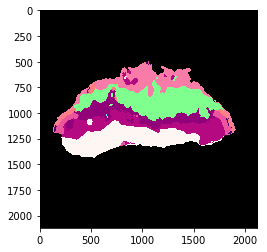

In [29]:
plt.imshow(rot_segmentation)

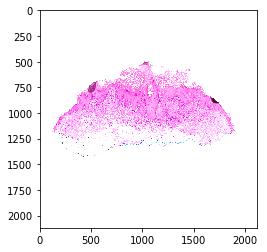

In [30]:
plt.imshow(rot_image)